<a href="https://colab.research.google.com/github/KANG-HYUNIL/AudioTrain/blob/main/ASC_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

기본 설치 및 환경 설정

In [1]:
!pip -q install torchaudio torchmetrics einops --index-url https://download.pytorch.org/whl/cu121 >/dev/null

import os, zipfile, urllib.request, random, math, shutil
from pathlib import Path

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio
from torchaudio import transforms as T
import torchmetrics
from einops import rearrange
import numpy as np
torch.manual_seed(42); np.random.seed(42); random.seed(42)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("PyTorch:", torch.__version__, "| torchaudio:", torchaudio.__version__, "| device:", DEVICE)


PyTorch: 2.8.0+cu126 | torchaudio: 2.8.0+cu126 | device: cuda


데이터셋 준비 및 분할

> 인용구 추가



In [2]:
# === (셀 2) 데이터 다운로드 및 분할: Speech Commands Dataset 사용 ===
# - 용량: 약 2GB (v0.02) 또는 1GB (v0.01). v0.02 사용 시 용량 초과 가능성 있음. v0.01 권장.
# - 클래스: 12개 (v0.02) 또는 10개 (v0.01) + unknown + silence
# - Torchaudio 내장 데이터셋 로더 사용

DATA_DIR = Path("/content/data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Speech Commands Dataset 로드
# root: 데이터셋 다운로드 및 저장 경로
# url: 사용할 데이터셋 버전 ('speech_commands_v0.02' 또는 'speech_commands_v0.01')
#     v0.02는 용량이 커서 Colab 무료 버전 디스크 공간을 초과할 수 있습니다.
#     v0.01 (약 1GB)을 사용하는 것을 권장합니다.
# download=True: 지정된 경로에 데이터셋이 없으면 다운로드합니다.

# 데이터셋 로드 (자동 다운로드)
# SpeechCommands 클래스는 학습/검증/테스트 분할을 자체적으로 제공합니다.
# 'training', 'validation', 'testing'
try:
    print("Loading Speech Commands Dataset (v0.01)...")
    # v0.01 로드 시도
    train_dataset_full = torchaudio.datasets.SPEECHCOMMANDS(root=DATA_DIR, url='speech_commands_v0.01', download=True)
    val_dataset = torchaudio.datasets.SPEECHCOMMANDS(root=DATA_DIR, url='speech_commands_v0.01', download=True, subset='validation')
    test_dataset = torchaudio.datasets.SPEECHCOMMANDS(root=DATA_DIR, url='speech_commands_v0.01', download=True, subset='testing') # 테스트셋도 로드 (여기서는 사용 안함)
    print("Speech Commands v0.01 loaded successfully.")

except Exception as e_v001:
    print(f"Failed to load v0.01: {e_v001}")
    print("Attempting to load Speech Commands Dataset (v0.02)...")
    # v0.01 실패 시 v0.02 로드 시도 (용량 주의)
    try:
        train_dataset_full = torchaudio.datasets.SPEECHCOMMANDS(root=DATA_DIR, url='speech_commands_v0.02', download=True)
        val_dataset = torchaudio.datasets.SPEECHCOMMANDS(root=DATA_DIR, url='speech_commands_v0.02', download=True, subset='validation')
        test_dataset = torchaudio.datasets.SPEECHCOMMANDS(root=DATA_DIR, url='speech_commands_v0.02', download=True, subset='testing')
        print("Speech Commands v0.02 loaded successfully.")
    except Exception as e_v002:
        print(f"Failed to load v0.02: {e_v002}")
        print("Error: Could not load Speech Commands Dataset.")
        # 데이터셋 로드 실패 시 이후 코드 실행이 어렵습니다.
        # 필요한 경우 수동 다운로드 및 로드 코드를 작성해야 합니다.
        train_dataset_full = None
        val_dataset = None
        test_dataset = None


# 데이터셋 로드 성공 시 클래스 이름 및 개수 확인
if train_dataset_full:
    # Speech Commands 데이터셋은 오디오 경로에서 직접 클래스 이름을 가져오거나,
    # 데이터셋 객체에 클래스 정보가 내장되어 있습니다.
    # 여기서는 예시로 데이터셋 내 파일 경로에서 클래스 이름을 추출합니다.
    # 실제 데이터셋 객체는 (waveform, sample_rate, label, speaker_id, utterance_number) 튜플을 반환합니다.
    # 라벨은 문자열 형태입니다.

    # 클래스 이름 목록 생성 (학습 데이터셋에서 고유한 라벨들을 추출)
    # 데이터셋이 크므로 모든 라벨을 로드하는 대신, 데이터셋 객체에 접근 가능한 클래스 목록을 사용합니다.
    # SPEECHCOMMANDS 데이터셋 객체는 .classes 속성을 제공하지 않습니다.
    # 따라서, 학습 데이터셋 파일 경로에서 클래스 이름을 추출하는 방법을 사용합니다.
    # 이 방법은 데이터셋 객체를 직접 사용하는 것보다 불편하지만, 클래스 목록을 얻기 위해 필요합니다.

    # 데이터셋 파일 경로 목록을 직접 탐색하여 클래스 이름 추출 (시간이 다소 소요될 수 있습니다)
    print("Collecting class names from dataset files...")
    all_classes = set()
    # Speech Commands 데이터셋의 구조에 맞춰 파일 경로를 탐색해야 합니다.
    # 기본 구조는 root/word/audio_file.wav 입니다.
    # 'training' subset의 경로를 직접 확인하여 클래스 목록을 만듭니다.
    # torchaudio.datasets.SPEECHCOMMANDS 객체는 파일 경로 목록을 직접 제공하지 않으므로,
    # 내부 경로를 탐색하거나, 데이터셋 객체를 순회하여 라벨을 수집해야 합니다.
    # 데이터셋 객체를 순회하는 방식은 매우 느릴 수 있습니다.
    # 여기서는 데이터가 저장된 실제 폴더 구조를 기반으로 클래스 이름을 찾습니다.
    # Speech Commands v0.01의 경우 기본적으로 root/_background_noise_/, root/word/audio.wav 구조입니다.
    # 'training' 폴더는 root/training/audio.wav 와 같은 구조가 아닐 수 있습니다.
    # SpeechCommands 로더는 파일 경로를 숨기고 (waveform, sr, label, ...) 튜플을 제공합니다.
    # 가장 쉬운 방법은 데이터셋 객체를 순회하며 라벨을 수집하는 것입니다. (매우 느림)
    # 또는, 데이터셋 문서나 소스 코드를 보고 클래스 목록을 확인하는 것입니다.
    # Speech Commands v0.01의 공식 클래스는 10개 단어 + unknown + silence 입니다.
    # 공식 문서에 따르면 v0.01의 10개 단어는: 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go'
    # v0.02의 12개 단어는 위 10개 + 'bed', 'bird', 'cat', 'dog', 'happy', 'house', 'marvin', 'sheila', 'silence', 'unknown', 'wow', 'zero'.
    # 'unknown'과 'silence'는 특별 처리될 수 있습니다.

    # 학습/검증 데이터셋 객체에서 라벨(클래스 이름)을 직접 추출하여 클래스 목록 생성 (시간이 오래 걸릴 수 있습니다!)
    # 데이터셋이 크므로 모든 샘플을 순회하는 것은 비효율적입니다.
    # SpeechCommands 데이터셋의 라벨은 문자열로 제공됩니다.
    # 여기서는 하드코딩된 클래스 이름 목록을 사용합니다.
    # 실제 데이터셋 버전(v0.01 또는 v0.02)에 따라 CLASS_NAMES를 조정해야 합니다.

    # v0.01 클래스 이름 (10개 단어 + unknown + silence)
    # Speech Commands 데이터셋의 'unknown' 및 'silence' 라벨은 일반적으로 특별 클래스로 처리되거나 제외될 수 있습니다.
    # 여기서는 10개 단어 클래스만 사용하도록 필터링합니다.
    # 나중에 필요한 경우 'unknown' 및 'silence'를 포함하도록 수정할 수 있습니다.
    # 또한, 학습/검증/테스트 분할은 SpeechCommands 로더가 자동으로 처리하므로,
    # 수동으로 파일을 복사하는 방식 대신 subset 인자를 사용합니다.

    # 학습/검증 데이터셋 객체 정의는 이 셀에서 완료하고,
    # DataLoader 생성은 다음 셀(셀 4)에서 진행합니다.

    # 클래스 이름을 정의합니다. 실제 사용될 클래스만 포함합니다.
    # v0.01 기준 10개 단어 클래스만 사용
    CLASS_NAMES = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
    # 만약 'unknown'과 'silence'를 포함하려면:
    # CLASS_NAMES = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', '_unknown_', '_silence_']
    # v0.02 기준 클래스도 유사하게 정의 가능

    print("Using CLASS_NAMES:", CLASS_NAMES)
    print("Number of classes:", len(CLASS_NAMES))

    # 학습/검증 데이터셋 크기 출력 (subset으로 로드했으므로 바로 사용 가능)
    print("Train/Val dataset sizes (before filtering):", len(train_dataset_full), len(val_dataset))

    # Speech Commands 데이터셋 객체는 (waveform, sample_rate, label, speaker_id, utterance_number) 튜플을 반환합니다.
    # 여기서는 지정된 CLASS_NAMES에 포함된 라벨만 사용하도록 데이터셋을 필터링해야 합니다.
    # 사용자 정의 Dataset 클래스 (다음 셀)에서 로딩 시 필터링을 수행하도록 합니다.
    # 이 셀에서는 데이터셋 객체 로드까지만 수행합니다.


else:
    # 데이터셋 로드 실패 시 CLASS_NAMES를 빈 목록으로 설정
    CLASS_NAMES = []
    train_dataset_full = None
    val_dataset = None
    print("Dataset loading failed. Please check the error messages above.")

# 다음 셀 (셀 4)에서 이 데이터셋 객체(train_dataset_full, val_dataset)를 사용하여 DataLoader를 생성합니다.
# CLASS_NAMES 변수는 전역으로 사용 가능합니다.

Loading Speech Commands Dataset (v0.01)...
Speech Commands v0.01 loaded successfully.
Using CLASS_NAMES: ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
Number of classes: 10
Train/Val dataset sizes (before filtering): 64721 6798


PreProcessing / Augmentation

In [3]:
# === (셀 3) 오디오 전처리 및 증강 변환 정의 ===
# 모델 입력으로 사용할 멜 스펙트로그램을 생성하고 데이터 증강을 적용하는 함수들을 정의합니다.

# 목표 샘플레이트 (TARGET_SR): 오디오 신호를 이 샘플레이트로 리샘플링합니다.
TARGET_SR = 32000
# 멜 필터뱅크 개수 (N_MELS): 멜 스펙트로그램의 주파수 축 해상도입니다.
N_MELS = 128
# FFT 크기 (N_FFT): Short-Time Fourier Transform (STFT)을 수행할 때 사용하는 FFT 윈도우 크기입니다.
N_FFT = 1024
# HOP 길이 (HOP): STFT 윈도우가 다음 위치로 이동하는 간격입니다. 오디오 신호의 시간 해상도와 관련됩니다.
HOP = 320  # 10ms@32kHz 정도에 해당합니다 (10ms * 32000Hz/s = 320 samples)
# 최소/최대 주파수 (FMIN, FMAX): 멜 스펙트로그램 계산에 사용할 주파수 범위입니다.
FMIN, FMAX = 20.0, 16000.0

# 리샘플러 (resampler): 원본 샘플레이트(44100Hz, 셀 2에서 TFDS 데이터 리샘플링 기준)를 목표 샘플레이트(TARGET_SR)로 변환합니다.
# torchaudio.transforms.Resample(orig_freq, new_freq) 객체를 생성합니다.
resampler = T.Resample(orig_freq=44100, new_freq=TARGET_SR)

# 멜 스펙트로그램 변환 (mel): 오디오 웨이브폼으로부터 멜 스펙트로그램을 계산합니다.
# torchaudio.transforms.MelSpectrogram(...) 객체를 생성합니다.
mel = T.MelSpectrogram(
    sample_rate=TARGET_SR, # 목표 샘플레이트
    n_fft=N_FFT,           # FFT 크기
    hop_length=HOP,        # HOP 길이
    n_mels=N_MELS,         # 멜 필터뱅크 개수
    f_min=FMIN, f_max=FMAX, # 주파수 범위
    power=2.0              # 파워 스펙트로그램 (에너지) 사용
)
# 데시벨 변환 (to_db): 멜 스펙트로그램의 에너지를 데시벨(dB) 스케일로 변환합니다.
# 소리의 크기는 로그 스케일로 인지되므로, dB 스케일로 변환하는 것이 일반적입니다.
to_db = T.AmplitudeToDB()

# SpecAugment (학습시에만 적용)
# 스펙트로그램에 마스크를 적용하여 데이터 증강을 수행합니다.
# TimeMasking: 스펙트로그램의 특정 시간 구간을 마스킹합니다.
# time_mask_param=24: 마스킹할 최대 시간 스텝 수입니다. (HOP=320이므로 24*320 샘플 정도)
# p=0.8: Time Masking을 적용할 확률입니다.
time_mask = T.TimeMasking(time_mask_param=24, p=0.8) # 약 ~240ms (24 * HOP/TARGET_SR 초)
# FrequencyMasking: 스펙트로그램의 특정 주파수 대역을 마스킹합니다.
# freq_mask_param=16: 마스킹할 최대 멜 주파수 밴드 수입니다.
freq_mask = T.FrequencyMasking(freq_mask_param=16) # 약 ~16 mel bands

# 웨이브폼을 로그 멜 스펙트로그램으로 변환하는 함수
def wav_to_logmel(wav, sr):
    # wav: 입력 웨이브폼 텐서 (channels, samples)
    # sr: 입력 웨이브폼의 샘플레이트

    # 입력 샘플레이트가 목표 샘플레이트와 다르면 리샘플링 수행
    if sr != TARGET_SR:
        wav = resampler(wav)
    # 스테레오(channels > 1)이면 모노 채널로 변환 (평균 사용)
    if wav.shape[0] > 1:  # stereo → mono
        wav = wav.mean(dim=0, keepdim=True) # 채널 차원에서 평균, keepdim=True로 차원 유지 (1, samples)

    # 멜 스펙트로그램 계산
    S = mel(wav)           # (1, n_mels, time) - 채널 차원 1 유지

    # 데시벨 스케일로 변환
    S = to_db(S) # (1, n_mels, time)

    return S # 로그 멜 스펙트로그램 텐서 반환

# 스펙트로그램에 데이터 증강을 적용하는 함수 (SpecAugment)
def augment_spec(spec):
    # spec shape: (1, n_mels, time) - 로그 멜 스펙트로그램 텐서

    # 입력 텐서 복사 (원본 변경 방지)
    s = spec.clone()

    # Time Masking 적용
    s = time_mask(s)
    # Frequency Masking 적용
    s = freq_mask(s)

    return s # 증강된 스펙트로그램 텐서 반환

Dataset / DataLoader

In [4]:
# === (셀 4) Dataset 및 DataLoader 정의 ===
# 셀 2에서 로드한 Speech Commands 데이터셋 객체를 사용하여 DataLoader를 설정합니다.

from torch.nn.utils.rnn import pad_sequence # 시퀀스 패딩을 위한 함수 임포트

# 스펙트로그램의 시간 차원을 고정할 최대 길이 설정
# Speech Commands 샘플은 보통 1초(32000 샘플) 이내이며, HOP=320이므로 시간 스텝은 약 100입니다.
# 디버깅 출력에서 30-40대의 길이가 관찰되었지만, 안전하게 넉넉한 길이로 설정합니다.
MAX_SPEC_TIME_STEPS = 100

# 사용자 정의 데이터셋 클래스 (PyTorch의 Dataset 상속)
# Speech Commands 데이터셋 객체를 받아서 스펙트로그램 변환 및 필터링, 고정 길이 패딩을 수행합니다.
class SpeechCommandsDatasetWrapper(Dataset):
    # dataset: 셀 2에서 로드된 torchaudio.datasets.SPEECHCOMMANDS 객체 (subset이 적용된 상태일 수 있음)
    # class_names: 사용할 클래스 이름 목록 (셀 2에서 정의된 CLASS_NAMES)
    # train: 학습 데이터셋인지 (True) 검증 데이터셋인지 (False) 구분 (증강 적용 여부 결정)
    # apply_specaug: 데이터 증강(SpecAugment)을 적용할지 여부
    def __init__(self, dataset, class_names, train=True, apply_specaug=True):
        self.dataset = dataset # 원본 데이터셋 객체 저장
        self.class_names = class_names # 사용할 클래스 이름 목록 저장
        self.train = train # 학습/검증 모드 저장
        self.apply_specaug = apply_specaug # 증강 적용 여부 저장

        # 클래스 이름과 인덱스 매핑 딕셔너리 생성
        # 예: {'yes': 0, 'no': 1, ...}
        self.class_to_idx = {c_name: i for i, c_name in enumerate(self.class_names)}

        # 사용할 샘플 인덱스 목록 생성 (지정된 class_names에 포함된 라벨만 사용)
        print(f"Filtering dataset for classes: {self.class_names}...")
        # Speech Commands 데이터셋은 (waveform, sample_rate, label, speaker_id, utterance_number) 튜플을 반환합니다.
        # 여기서 label (튜플의 세 번째 요소, 인덱스 2)이 지정된 class_names 목록에 있는지 확인합니다.
        self.indices = [i for i in range(len(self.dataset)) if self.dataset[i][2] in self.class_names]
        print(f"Filtered down to {len(self.indices)} samples.")

        # 필터링된 샘플 개수 확인 (경고 메시지 출력)
        if len(self.indices) == 0:
            print(f"Warning: No samples found for the specified classes after filtering.")


    # 데이터셋의 전체 샘플 개수를 반환하는 메서드 (필수 구현)
    # 필터링된 샘플의 개수를 반환합니다.
    def __len__(self):
        return len(self.indices)

    # 인덱스(idx)에 해당하는 데이터 샘플을 반환하는 메서드 (필수 구현)
    def __getitem__(self, idx):
        # idx: 요청된 데이터 샘플의 필터링된 인덱스 목록 내에서의 인덱스

        # 필터링된 인덱스 목록에서 실제 데이터셋의 인덱스를 가져옴
        original_idx = self.indices[idx]

        # 원본 데이터셋에서 데이터 가져오기
        # Speech Commands 데이터셋 샘플: (waveform, sample_rate, label, speaker_id, utterance_number)
        waveform, sample_rate, label_name, _, _ = self.dataset[original_idx]

        # 클래스 이름(label_name)을 미리 정의된 인덱스(self.class_to_idx)로 변환
        y = self.class_to_idx[label_name]

        # 웨이브폼을 로그 멜 스펙트로그램으로 변환 (셀 3에서 정의된 함수 사용)
        # spec shape: (1, n_mels, time)
        spec = wav_to_logmel(waveform, sample_rate)

        # 학습 모드이고 증강 적용이 활성화된 경우 SpecAugment 적용
        if self.train and self.apply_specaug:
            spec = augment_spec(spec)

        # --- 고정 길이 패딩 추가 ---
        # 스펙트로그램의 시간 차원(마지막 차원, 인덱스 2) 길이를 MAX_SPEC_TIME_STEPS로 맞춥니다.
        current_time_steps = spec.shape[2]
        if current_time_steps < MAX_SPEC_TIME_STEPS:
            # 패딩할 크기 계산 (오른쪽에 패딩)
            padding = (0, MAX_SPEC_TIME_STEPS - current_time_steps) # (left_pad, right_pad) for last dimension
            # F.pad(input, pad, value): 텐서 패딩 함수
            spec = F.pad(spec, padding, "constant", 0) # 0으로 채웁니다.
        elif current_time_steps > MAX_SPEC_TIME_STEPS:
            # 설정된 최대 길이보다 길면 잘라냅니다. (시작 부분부터 취함)
            spec = spec[:, :, :MAX_SPEC_TIME_STEPS]
        # --- 고정 길이 패딩 끝 ---


        # 스펙트로그램 표준화 (채널별)
        # 데이터의 평균을 0, 표준 편차를 1로 만들어 학습을 안정화합니다.
        # spec.mean(): 스펙트로그램 텐서 전체의 평균
        # spec.std(): 스펙트로그램 텐서 전체의 표준 편차
        # 1e-6: 분모가 0이 되는 것을 방지하기 위한 작은 값 (epsilon)
        spec = (spec - spec.mean()) / (spec.std() + 1e-6)

        # 전처리 및 증강이 완료된 스펙트로그램 텐서와 클래스 인덱스(라벨) 반환
        return spec, y

# DataLoader를 위한 커스텀 collate 함수
# 이 함수는 DataLoader가 배치 단위로 샘플들을 묶을 때 사용됩니다.
# 배치 내의 샘플들(여기서는 스펙트로그램과 라벨 튜플의 리스트)을 입력받아
# 스펙트로그램들을 패딩하고 라벨 텐서를 만듭니다.
# __getitem__에서 이미 고정 길이 패딩을 했으므로, 이 함수에서는 별도의 패딩 없이 바로 스택합니다.
def pad_collate(batch):
    # batch: [(spec1, label1), (spec2, label2), ...] 형태의 리스트
    # __getitem__에서 이미 고정 길이 패딩을 거쳤으므로, 모든 spec의 shape이 동일합니다.

    # 배치에서 스펙트로그램과 라벨 분리
    specs, labels = zip(*batch) # zip(*...)은 리스트 언팩 후 다시 묶어줌

    # --- 디버깅 코드 추가 (형태 확인용) ---
    # print("--- Inside pad_collate ---")
    # for i, spec_tensor in enumerate(specs):
    #     # 스펙트로그램 텐서의 shape, ndim, is_contiguous 출력
    #     print(f"Sample {i} shape: {spec_tensor.shape}, ndim: {spec_tensor.ndim}, is_contiguous: {spec_tensor.is_contiguous()}")
    #     if spec_tensor.ndim > 1:
    #          print(f"  Freq dim size (dim 1): {spec_tensor.shape[1]}")
    #     if spec_tensor.ndim > 2: # Time dimension is index 2 for (C, F, T)
    #          print(f"  Time dim size (dim 2): {spec_tensor.shape[2]}")
    # print("--------------------------")
    # --- 디버깅 코드 끝 ---


    # 스펙트로그램 스택 (Stack)
    # __getitem__에서 이미 모든 스펙트로그램의 형태를 (1, N_MELS, MAX_SPEC_TIME_STEPS)로 맞췄으므로,
    # pad_sequence 대신 torch.stack을 사용하여 바로 배치 텐서로 만듭니다.
    # stack(tensors, dim=0)는 리스트 안의 텐서들을 dim=0을 기준으로 쌓아 새로운 차원을 만듭니다.
    # 결과 shape: (Batch, Channels, Freq, Time) -> (BATCH, 1, N_MELS, MAX_SPEC_TIME_STEPS)
    stacked_specs = torch.stack(specs, dim=0)


    # 라벨 텐서 생성
    # 라벨(정수) 리스트를 PyTorch 텐서로 변환합니다.
    # dtype=torch.long: 분류 라벨은 일반적으로 long 타입 텐서로 사용됩니다.
    label_tensor = torch.tensor(labels, dtype=torch.long)

    # 패딩된 스펙트로그램 배치 텐서와 라벨 배치 텐서 반환
    return stacked_specs, label_tensor


# Mixup 데이터 증강 함수 (선택 사항)
# 배치 단위로 두 개의 샘플을 선형적으로 혼합하여 새로운 샘플을 생성합니다.
# x: 입력 스펙트로그램 배치 텐서
# y: 입력 라벨 배치 텐서
# alpha: Mixup 강도 조절 파라미터 (베타 분포의 alpha)
def mixup_batch(x, y, alpha=0.2):
    # alpha가 0 이하이면 Mixup을 적용하지 않고 원본 데이터 반환
    if alpha <= 0: return x, y, None

    # 베타 분포에서 람다(lam) 값 샘플링
    # 람다는 두 샘플을 혼합할 비율을 결정합니다 (0 ~ 1 사이 값).
    lam = np.random.beta(alpha, alpha)

    # 배치 크기 가져오기
    batch_size = x.size(0)

    # 배치 내 샘플 순서를 무작위로 섞는 인덱스 생성
    index = torch.randperm(batch_size, device=x.device)

    # Mixup 적용: 원본 배치와 순서가 섞인 배치를 람다 비율로 혼합
    mixed_x = lam*x + (1-lam)*x[index]

    # 라벨도 Mixup에 맞춰 혼합 (Knowledge Distillation loss에서 사용)
    # y_a: 원본 라벨 배치, y_b: 순서가 섞인 라벨 배치
    y_a, y_b = y, y[index]

    # 혼합된 스펙트로그램, 혼합된 라벨 튜플, 람다 값 반환
    return mixed_x, (y_a, y_b), lam


# 배치 크기 설정
BATCH = 32 # 한 번에 처리할 데이터 샘플의 개수

# 셀 2에서 로드된 데이터셋 객체 (train_dataset_full, val_dataset)와
# 정의된 클래스 이름 목록 (CLASS_NAMES)을 사용하여 Wrapper 데이터셋 객체 생성

if train_dataset_full and val_dataset and CLASS_NAMES:
    print("Creating wrapped datasets...")
    # 학습 데이터셋 객체 생성 (증강 적용)
    train_ds = SpeechCommandsDatasetWrapper(train_dataset_full, CLASS_NAMES, train=True, apply_specaug=True)
    # 검증 데이터셋 객체 생성 (증강 미적용)
    val_ds   = SpeechCommandsDatasetWrapper(val_dataset, CLASS_NAMES, train=False, apply_specaug=False)

    # 학습 데이터 DataLoader 생성
    # train_ds: 사용할 데이터셋 객체 (Wrapped Dataset)
    # batch_size: 배치 크기
    # shuffle=True: 학습 시에는 데이터를 매 epoch마다 섞음
    # num_workers: 데이터를 로드할 때 사용할 서브 프로세스 개수 (데이터 로딩 속도 향상)
    # pin_memory=True: GPU 사용 시 데이터 전송 속도 향상
    # collate_fn=pad_collate: 사용자 정의 collate 함수 지정 (스펙트로그램 패딩용)
    train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True, collate_fn=pad_collate)
    # 검증 데이터 DataLoader 생성
    # val_ds: 사용할 데이터셋 객체 (Wrapped Dataset)
    # batch_size: 배치 크기 (검증 시에는 보통 학습과 동일하게 설정)
    # shuffle=False: 검증 시에는 데이터 순서를 섞지 않음 (결과 재현성 확보)
    # collate_fn=pad_collate: 사용자 정의 collate 함수 지정 (스펙트로그램 패딩용)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True, collate_fn=pad_collate)

    # 데이터셋 크기 및 DataLoader에서 가져온 첫 번째 배치 형태 출력 (확인용)
    # len(train_ds): 학습 데이터셋 샘플 총 개수 (필터링 후)
    # len(val_ds): 검증 데이터셋 샘 샘플 총 개수 (필터링 후)
    print("Filtered Dataset sizes:", len(train_ds), len(val_ds))

    # 데이터셋 로딩에 성공하고 필터링 후 샘플이 남아있을 경우 첫 번째 배치 형태를 출력합니다.
    # 첫 번째 배치 형태를 출력하기 위해 DataLoader를 한 번 순회합니다.
    if len(train_ds) > 0:
        print("Shape of a batch from train_loader:", next(iter(train_loader))[0].shape)
    else:
        print("Cannot get batch shape as train_ds is empty after filtering.")

else:
    # 셀 2에서 데이터셋 로드 실패 시 DataLoader를 생성하지 않음
    print("Dataset loading failed in Cell 2. Skipping DataLoader creation.")
    train_ds = None
    val_ds = None
    train_loader = None
    val_loader = None

Creating wrapped datasets...
Filtering dataset for classes: ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']...


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Filtered down to 23682 samples.
Filtering dataset for classes: ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']...
Filtered down to 2577 samples.
Filtered Dataset sizes: 23682 2577
Shape of a batch from train_loader: torch.Size([32, 1, 128, 100])


Teacher / Student Model

In [5]:
# === (셀 5) Teacher 및 Student 모델 정의 ===
# 지식 증류(Knowledge Distillation)에 사용될 Teacher 모델과 Student 모델의 구조를 정의합니다.

# Teacher Model: PatchTransformer (ViT-inspired)
# 음성 스펙트로그램을 이미지처럼 패치로 나누어 Transformer 인코더로 처리하는 모델입니다.
# Student 모델보다 크고 복잡하여 더 높은 성능을 내는 것을 목표로 합니다.
class PatchTransformer(nn.Module):
    # 모델 생성자
    # n_mels: 입력 멜 스펙트로그램의 주파수 밴드 수 (height) - 셀 3의 N_MELS 사용
    # n_classes: 분류할 클래스 수 (Speech Commands는 10개 또는 12개) - 전역 변수 CLASS_NAMES의 길이를 사용
    # patch_f: 패치의 주파수 방향 크기
    # patch_t: 패치의 시간 방향 크기
    # d_model: Transformer의 임베딩 차원 (hidden size) - 각 패치 임베딩 및 Transformer 내부 연산 차원
    # depth: Transformer 인코더 레이어의 개수
    # heads: Multi-Head Attention의 헤드 개수
    # mlp_ratio: MLP (Feedforward) 레이어의 은닉층 크기 비율 (d_model * mlp_ratio)
    # dropout: 드롭아웃 비율 (과적합 방지)
    def __init__(self, n_mels=128, n_classes=11, patch_f=16, patch_t=16, d_model=128, depth=4, heads=4, mlp_ratio=2.0, dropout=0.1):
        super().__init__() # nn.Module의 생성자 호출
        self.patch_f, self.patch_t = patch_f, patch_t # 패치 크기 저장

        # 1. 스펙트로그램을 패치로 나누고 각 패치를 벡터로 펼치는 (flatten) 부분
        # 입력 스펙트로그램 shape: (Batch, Channels=1, Freq=n_mels, Time)
        # 패치로 나눈 후 reshape: (Batch, Num_Patches, Patch_Freq*Patch_Time)
        # 예: (B, 1, 128, T) -> 패치 크기 (16, 16) -> (B, (128/16)*(T/16), 16*16) -> (B, 8 * (T/16), 256)

        # 2. 각 패치 벡터를 d_model 차원의 임베딩 벡터로 선형 변환 (Projection)
        # 입력: (Batch, Num_Patches, patch_f*patch_t)
        # 출력: (Batch, Num_Patches, d_model) - Transformer 입력 차원
        self.proj = nn.Linear(patch_f*patch_t, d_model)

        # 3. 분류를 위한 특별한 토큰 (Class Token) 추가
        # 이 토큰은 Transformer를 거친 후 전체 시퀀스의 정보를 요약하여 분류에 사용됩니다.
        # shape: (1, 1, d_model) - 배치 차원은 나중에 확장됩니다. 학습 가능한 파라미터입니다.
        self.cls_token = nn.Parameter(torch.zeros(1,1,d_model))

        # 4. 위치 정보를 더해주는 Positional Embedding
        # Transformer는 순서 정보를 모르므로, 각 패치의 위치 정보를 임베딩하여 더해줍니다.
        # shape: (1, 최대 패치 수 + 1 (cls 토큰), d_model)
        # 충분히 큰 크기로 초기화하고 실제 패치 수만큼 잘라 사용합니다. 학습 가능한 파라미터입니다.
        self.pos = nn.Parameter(torch.randn(1, 1024, d_model)) # 1024는 임의로 충분히 크게 잡은 값

        # 5. Transformer Encoder 레이어 정의
        # self-attention 메커니즘을 통해 패치 간의 관계를 학습합니다.
        # d_model: 임베딩 차원
        # nhead: 멀티 헤드 어텐션의 헤드 수
        # dim_feedforward: 내부 MLP 레이어의 차원 (보통 d_model * 4)
        # dropout: 드롭아웃 비율
        # batch_first=True: 입력/출력 텐서의 첫 번째 차원이 배치 크기임을 명시 (PyTorch 1.9+ 기본값)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=heads, dim_feedforward=int(d_model*mlp_ratio), dropout=dropout, batch_first=True)
        # 여러 개의 인코더 레이어를 쌓아서 최종 인코더를 만듭니다. num_layers=depth로 깊이 설정.
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # 6. 최종 분류를 위한 Head (Classifier)
        # Transformer 인코더의 출력 중 Class Token에 해당하는 부분만 사용하여 분류합니다.
        # LayerNorm: 안정적인 학습을 위한 정규화 레이어
        # Linear: 최종 클래스 수만큼의 출력 로짓을 생성하는 완전 연결 레이어
        self.head = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, n_classes))

    # 모델의 순전파(forward) 계산 정의
    # x: 입력 멜 스펙트로그램 텐서 (Batch, Channels=1, Freq, Time)
    def forward(self, x):
        # 입력 텐서의 배치, 채널, 주파수, 시간 차원 가져오기
        # 변수명을 명확하게 변경하여 F.pad 함수와의 충돌을 방지합니다.
        batch_size, channels, freq_size, time_size = x.shape
        pf, pt = self.patch_f, self.patch_t # 패치 크기 가져오기

        # 입력 크기가 패치 크기의 배수가 아닐 경우 패딩 (Padding)
        # 스펙트로그램의 Freq와 Time 차원을 패치 크기의 배수가 되도록 0으로 채웁니다.
        Fpad = (pf - freq_size%pf) % pf # 주파수 차원에 필요한 패딩 크기
        Tpad = (pt - time_size%pt) % pt # 시간 차원에 필요한 패딩 크기
        if Fpad or Tpad:
            # F.pad(input, pad, mode='constant', value=0) - torch.nn.functional 모듈의 pad 함수 사용
            # pad: (pad_left, pad_right, pad_top, pad_bottom) 또는 (pad_dimN_low, pad_dimN_high, ...)
            # 여기서는 (0, Tpad, 0, Fpad) -> 시간 차원 오른쪽에 Tpad, 주파수 차원 아래쪽에 Fpad 패딩
            x = F.pad(x, (0,Tpad,0,Fpad))
            # 패딩 후 새로운 Freq, Time 크기 업데이트
            batch_size, channels, freq_size, time_size = x.shape

        # 패치로 나누고 펼치기 (Rearrange from einops 라이브러리 사용)
        # 'b c (f pf) (t pt) -> b (f t) (pf pt)' 는
        # (Batch, Channel, Freq, Time) 텐서를
        # Freq를 pf 크기의 블록으로, Time을 pt 크기의 블록으로 나누고 (f, t는 블록의 개수)
        # 각 블록(pf*pt)을 벡터로 펼쳐서
        # (Batch, Num_Patches = f*t, Patch_Flatten_Size = pf*pt) 형태로 만듭니다.
        x = rearrange(x, 'b c (f pf) (t pt) -> b (f t) (c pf pt)', pf=pf, pt=pt)

        # 패치 임베딩 (Projection)
        # (Batch, Num_Patches, patch_f*patch_t) -> (Batch, Num_Patches, d_model)
        x = self.proj(x)

        # Class Token 추가
        # (Batch, 1, d_model) 형태의 cls_token을 현재 배치 크기(B)만큼 확장하여
        # 패치 임베딩 텐서의 맨 앞에 붙입니다.
        # 결과 shape: (Batch, Num_Patches + 1, d_model)
        cls = self.cls_token.expand(batch_size, -1, -1) # 배치 크기만큼 확장
        x = torch.cat([cls, x], dim=1) # 시퀀스 차원(dim=1)을 따라 결합

        # Positional Embedding 더하기
        # 미리 정의된 위치 임베딩에서 현재 시퀀스 길이(Num_Patches + 1)만큼 잘라와서 더합니다.
        x = x + self.pos[:, :x.size(1)]

        # Transformer Encoder 통과
        # (Batch, Num_Patches + 1, d_model) -> (Batch, Num_Patches + 1, d_model)
        x = self.encoder(x)

        # 최종 분류 결과를 위해 Class Token의 출력만 사용
        # (Batch, Num_Patches + 1, d_model) 텐서에서 Class Token에 해당하는 첫 번째 요소 (인덱스 0)만 가져옵니다.
        # 결과 shape: (Batch, d_model)
        # 이 결과를 Linear Head에 통과시켜 최종 로짓을 얻습니다.
        return self.head(x[:,0])

# Student Model: StudentCNN (Depthwise Separable Convolution 기반)
# Teacher보다 훨씬 가볍고 효율적인 CNN 모델입니다.
# 지식 증류를 통해 Teacher 모델의 성능을 따라가는 것을 목표로 합니다.
class DSConvBlock(nn.Module):
    # Depthwise Separable Convolution 블록 정의
    # 일반 컨볼루션보다 연산량이 적어 경량 모델에 유리합니다.
    # cin: 입력 채널 수
    # cout: 출력 채널 수
    # k: 커널 크기 (height, width)
    # s: 스트라이드 (height, width) - 컨볼루션 윈도우 이동 간격
    # p: 패딩 (height, width) - 입력 주변에 추가할 0의 크기
    def __init__(self, cin, cout, k=3, s=1, p=1):
        super().__init__() # nn.Module의 생성자 호출
        # 1. Depthwise Convolution: 입력 채널별로 독립적으로 컨볼루션 수행
        # groups=cin: 입력 채널 수만큼 그룹을 나누어 각 채널별로 필터 적용
        # 입력: (Batch, cin, H, W), 출력: (Batch, cin, H', W')
        self.depth = nn.Conv2d(cin, cin, k, s, p, groups=cin, bias=False) # bias=False는 BatchNorm 사용 시 일반적
        # 2. Pointwise Convolution: 1x1 컨볼루션을 통해 채널 간의 조합 수행
        # 입력: (Batch, cin, H', W'), 출력: (Batch, cout, H', W')
        self.point = nn.Conv2d(cin, cout, 1, 1, 0, bias=False) # 1x1 커널, 스트라이드 1, 패딩 0
        # 3. Batch Normalization: 배치 단위 정규화로 학습 안정화 및 가속화
        self.bn = nn.BatchNorm2d(cout) # 출력 채널 수에 맞춰 BatchNorm 초기화
        # 4. Activation Function: 비선형성 추가 (SiLU)
        self.act = nn.SiLU() # SiLU는 Sigmoid-Linear Unit으로 ReLU와 유사하지만 더 부드러운 활성화 함수

    # DSConvBlock의 순전파 계산 정의
    # x: 입력 텐서 (Batch, cin, H, W)
    def forward(self, x):
        x = self.depth(x) # Depthwise Conv 통과
        x = self.point(x) # Pointwise Conv 통과
        x = self.bn(x)    # Batch Norm 통과
        return self.act(x) # 활성화 함수 적용 결과 반환

class StudentCNN(nn.Module):
    # StudentCNN 모델 생성자
    # n_classes: 분류할 클래스 수 (Speech Commands는 10개 또는 12개) - 전역 변수 CLASS_NAMES의 길이를 사용
    def __init__(self, n_classes=11):
        super().__init__() # nn.Module의 생성자 호출
        # DSConvBlock들을 순차적으로 쌓아 CNN 모델 구성 (nn.Sequential 사용)
        self.net = nn.Sequential(
            # 첫 번째 블록: 입력 채널 1 (스펙트로그램), 출력 채널 32, 커널 5x5, 스트라이드 2x2, 패딩 2
            # 스펙트로그램의 시간/주파수 차원을 절반으로 줄입니다.
            DSConvBlock(1, 32, 5, 2, 2),
            # 두 번째 블록: 입력 채널 32, 출력 채널 64, 커널 3x3, 스트라이드 2x2, 패딩 1
            # 시간/주파수 차원을 또 절반으로 줄입니다.
            DSConvBlock(32, 64, 3, 2, 1),
            # 세 번째 블록: 입력 채널 64, 출력 채널 128, 커널 3x3, 스트라이드 2x2, 패딩 1
            # 시간/주파수 차원을 또 절반으로 줄입니다.
            DSConvBlock(64, 128, 3, 2, 1),
            # AdaptiveAvgPool2d: 입력 크기에 상관없이 출력 크기를 (1,1)로 만듭니다.
            # 이를 통해 마지막 컨볼루션 레이어의 공간 차원(Freq, Time)을 줄이고 전역 평균 풀링 효과를 얻습니다.
            # 결과 shape: (Batch, Channels, 1, 1)
            nn.AdaptiveAvgPool2d((1,1)),
            # Flatten: (Batch, Channels, 1, 1) 형태를 (Batch, Channels) 형태로 펼칩니다.
            # Linear 레이어에 입력으로 전달하기 위해 사용합니다.
            # 결과 shape: (Batch, 128) - 이전 AdaptiveAvgPool2d의 출력 채널 수
            nn.Flatten(),
            # Linear: 최종 분류를 위한 완전 연결 레이어
            # 입력: Flatten된 텐서의 크기 (128), 출력: 클래스 수 (n_classes)
            nn.Linear(128, n_classes)
        )

    # StudentCNN의 순전파 계산 정의
    # x: 입력 멜 스펙트로그램 텐서 (Batch, Channels=1, Freq, Time)
    def forward(self, x):
        # Sequential 모델에 입력 텐서를 통과시켜 최종 결과 반환
        return self.net(x)

# Teacher 모델과 Student 모델 인스턴스 생성
# n_classes 인자에 전역 변수 CLASS_NAMES의 길이를 전달하여 클래스 수에 맞게 모델을 초기화합니다.
# .to(DEVICE): 모델의 모든 파라미터와 버퍼를 지정된 디바이스(GPU 또는 CPU)로 이동시킵니다.
# DEVICE 변수는 셀 1에서 torch.cuda.is_available()에 따라 "cuda" 또는 "cpu"로 설정되었습니다.
# CLASS_NAMES가 셀 2에서 성공적으로 로드된 경우에만 모델을 생성합니다.
if CLASS_NAMES:
    teacher = PatchTransformer(n_mels=N_MELS, n_classes=len(CLASS_NAMES)).to(DEVICE)
    student = StudentCNN(n_classes=len(CLASS_NAMES)).to(DEVICE)

    # 모델의 학습 가능한 파라미터 수를 계산하는 함수
    def count_params(m):
        # m.parameters(): 모델 m의 모든 파라미터(가중치, 편향 등)를 가져옵니다.
        # p.requires_grad: 해당 파라미터가 학습 가능한지 (기울기 계산이 필요한지) 여부
        # sum(p.numel() for p in ...): requires_grad가 True인 파라미터들의 개수(numel())를 모두 더합니다.
        return sum(p.numel() for p in m.parameters() if p.requires_grad)

    # Teacher 모델과 Student 모델의 학습 가능한 파라미터 수 출력
    print("Teacher params:", count_params(teacher), "| Student params:", count_params(student))
else:
    print("CLASS_NAMES not defined. Skipping model creation.")
    teacher = None
    student = None
    # count_params 함수도 모델이 없으면 호출할 수 없으므로 조건부 또는 별도 처리 필요.
    # 여기서는 간단히 메시지만 출력하고 모델 객체를 None으로 둡니다.

Teacher params: 695562 | Student params: 12899


Knowledge Distillation

In [6]:
from torchmetrics.classification import MulticlassAccuracy

# === (셀 6) 평가 및 지식 증류 관련 함수 정의 ===
# 모델 성능을 평가하는 함수와 지식 증류 손실 함수, 그리고 KD 학습 함수를 정의합니다.

# 모델 성능 평가 함수
# model: 평가할 PyTorch 모델 (Teacher 또는 Student)
# loader: 평가에 사용할 DataLoader (train_loader 또는 val_loader)
def evaluate(model, loader):
    # 모델이 유효한지 확인 (셀 5에서 로드 실패 시 None일 수 있음)
    if model is None or loader is None:
        print("Model or DataLoader is not available for evaluation.")
        return 0.0, 0.0 # 유효하지 않으면 손실 0, 정확도 0 반환

    # 모델을 평가 모드로 설정 (Dropout, BatchNorm 등이 평가 모드로 동작)
    model.eval()
    # 다중 클래스 정확도 계산을 위한 torchmetrics 객체 생성
    # num_classes: 분류할 클래스 개수 (전역 변수 CLASS_NAMES의 길이를 사용)
    # .to(DEVICE): 메트릭 객체를 모델과 동일한 디바이스로 이동
    metric = MulticlassAccuracy(num_classes=len(CLASS_NAMES)).to(DEVICE)
    loss_sum, n = 0.0, 0 # 총 손실 합계 및 샘플 개수 초기화
    ce = nn.CrossEntropyLoss() # Cross Entropy Loss 함수 정의 (정답 라벨에 대한 손실 계산)

    # 그래디언트 계산 비활성화 (평가 시에는 역전파가 필요 없으므로 메모리 절약 및 속도 향상)
    with torch.no_grad():
        # DataLoader에서 배치 단위로 데이터(x: 스펙트로그램, y: 라벨) 가져오기
        for x, y in loader:
            # 데이터와 라벨을 모델과 동일한 디바이스로 이동
            x, y = x.to(DEVICE), y.to(DEVICE)

            # 모델의 순전파 (로짓 계산)
            logits = model(x) # logits shape: (Batch, n_classes)

            # Cross Entropy 손실 계산
            loss = ce(logits, y)

            # 배치 손실을 전체 손실 합계에 누적 (배치 크기만큼 가중)
            loss_sum += loss.item()*x.size(0)
            # 전체 샘플 개수 누적
            n += x.size(0)

            # 정확도 메트릭 업데이트
            metric.update(logits, y) # 로짓과 정답 라벨을 메트릭 객체에 전달

    # 전체 손실 평균 계산 (총 손실 합계 / 전체 샘플 개수)
    avg_loss = loss_sum / n
    # 누적된 메트릭 값 계산 (전체 데이터셋에 대한 최종 정확도)
    accuracy = metric.compute().item() # compute()는 Tensor를 반환하므로 .item()으로 스칼라 값 추출

    # 평균 손실과 정확도 반환
    return avg_loss, accuracy

# 지식 증류(Knowledge Distillation) 손실 함수
# student_logits: Student 모델의 출력 로짓
# teacher_logits: Teacher 모델의 출력 로짓
# y: 정답 라벨 (Hard Label)
# T: Temperature (Soft Target의 부드러움을 조절)
# alpha: Hard Target CE Loss와 Soft Target KD Loss의 가중치 균형 (alpha*CE + (1-alpha)*KD)
def kd_loss(student_logits, teacher_logits, y, T=2.0, alpha=0.5):
    # 1. Hard Target Cross Entropy Loss
    # Student 모델의 로짓과 정답 라벨(y) 간의 Cross Entropy 손실 계산
    ce = F.cross_entropy(student_logits, y)

    # 2. Soft Target Knowledge Distillation Loss (KL Divergence)
    # Student 모델의 Softmax 출력(Temperature 적용)과 Teacher 모델의 Softmax 출력(Temperature 적용) 간의 KL Divergence 계산
    # F.log_softmax(input/T, dim=1): Student 로짓에 Temperature T를 나누고 log_softmax 적용
    # F.softmax(input/T, dim=1): Teacher 로짓에 Temperature T를 나누고 softmax 적용
    # reduction="batchmean": 배치 평균으로 손실 계산
    # * (T*T): Temperature T로 나누었으므로, KL Divergence 스케일을 원래대로 복원하기 위해 T^2를 곱함
    kd = F.kl_div(
        F.log_softmax(student_logits/T, dim=1), # Student Softmax (log 스케일)
        F.softmax(teacher_logits/T, dim=1),     # Teacher Softmax (선형 스케일)
        reduction="batchmean"                   # 배치 평균
    ) * (T*T) # 스케일 복원

    # 최종 KD Loss: Hard CE Loss와 Soft KD Loss를 alpha 비율로 혼합
    return alpha*ce + (1-alpha)*kd

# Teacher 모델 학습 함수
# model: 학습할 Teacher 모델
# epochs: 학습할 epoch 수
# lr: 학습률 (Learning Rate)
# loader: 학습에 사용할 DataLoader
def train_teacher(model, loader, epochs=3, lr=3e-4):
    # 모델이 유효한지 확인
    if model is None or loader is None:
        print("Teacher model or DataLoader is not available for training.")
        return

    # AdamW 옵티마이저 생성 (가중치 감쇠(weight decay) 포함된 Adam)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    ce = nn.CrossEntropyLoss() # Cross Entropy Loss 함수 정의 (여기서는 일반 분류 학습)

    # 지정된 epoch 수만큼 반복 학습
    for ep in range(1, epochs+1):
        # 모델을 학습 모드로 설정 (Dropout, BatchNorm 등이 학습 모드로 동작)
        model.train()
        # train_loader에서 배치 단위로 데이터 가져오기
        for x, y in loader:
            # 데이터와 라벨을 모델과 동일한 디바이스로 이동
            x, y = x.to(DEVICE), y.to(DEVICE)

            # 모델 순전파 (로짓 계산)
            logits = model(x)
            # 손실 계산 (정답 라벨 y에 대한 Cross Entropy)
            loss = ce(logits, y)

            # 역전파 및 옵티마이저 스텝
            opt.zero_grad() # 이전 스텝에서 계산된 그래디언트 초기화
            loss.backward() # 현재 손실에 대한 그래디언트 계산
            opt.step()      # 계산된 그래디언트를 사용하여 모델 파라미터 업데이트

        # 각 epoch 종료 후 학습 및 검증 데이터셋에 대한 성능 평가
        # train_loader 대신 학습에 사용된 loader를 전달
        tr, tra = evaluate(model, loader) # 학습 데이터 평가 (손실, 정확도)
        va, vaa = evaluate(model, val_loader)   # 검증 데이터 평가 (손실, 정확도)
        # 평가 결과 출력
        print(f"[Teacher] ep{ep} | train acc {tra:.3f} loss {tr:.3f} | val acc {vaa:.3f} loss {va:.3f}")

# Student 모델 지식 증류 학습 함수
# student: 학습할 Student 모델
# teacher: 지식을 전달할 Teacher 모델
# epochs: 학습할 epoch 수
# lr: 학습률
# T: Temperature (KD Loss에 사용)
# alpha: Hard CE Loss와 Soft KD Loss의 가중치 균형 (KD Loss에 사용)
# mixup_alpha: Mixup 데이터 증강 강도 (0이면 Mixup 미적용)
# loader: 학습에 사용할 DataLoader
def train_student_kd(student, teacher, loader, epochs=5, lr=5e-4, T=2.0, alpha=0.5, mixup_alpha=0.2):
    # Student, Teacher 모델 또는 DataLoader가 유효한지 확인
    if student is None or teacher is None or loader is None:
        print("Student/Teacher model or DataLoader is not available for training.")
        return

    # Teacher 모델을 평가 모드로 설정 (학습 중 파라미터 업데이트 방지 및 일관된 Soft Target 제공)
    teacher.eval()
    # Student 모델 학습을 위한 AdamW 옵티마이저 생성
    opt = torch.optim.AdamW(student.parameters(), lr=lr)

    # 지정된 epoch 수만큼 반복 학습
    for ep in range(1, epochs+1):
        # Student 모델을 학습 모드로 설정
        student.train()
        # train_loader에서 배치 단위로 데이터 가져오기
        for x, y in loader:
            # 데이터와 라벨을 모델과 동일한 디바이스로 이동
            x, y = x.to(DEVICE), y.to(DEVICE)

            # mixup (선택 사항)
            # mixup_batch 함수를 사용하여 데이터 혼합 (mixup_alpha > 0일 경우)
            # x_m: Mixup된 스펙트로그램 배치
            # y_mix: Mixup된 라벨 (튜플 형태: (원본 라벨 배치, 섞인 라벨 배치))
            # lam: Mixup 혼합 비율
            x_m, y_mix, lam = mixup_batch(x, y, alpha=mixup_alpha)

            # Mixup이 적용된 경우 (lam이 None이 아닌 경우)
            if lam is not None:
                # Teacher 모델의 로짓 계산 (Mixup된 데이터 사용, 그래디언트 계산 비활성화)
                with torch.no_grad(): # Teacher는 학습하지 않으므로 그래디언트 계산 불필요
                    t_logits = teacher(x_m)
                # Student 모델의 로짓 계산 (Mixup된 데이터 사용)
                s_logits = student(x_m)
                # Mixup에 맞춰 KD Loss 계산 (두 라벨에 대한 KD Loss를 람다 비율로 가중합)
                loss = (lam*kd_loss(s_logits, t_logits, y_mix[0], T, alpha) # 원본 라벨 y_mix[0]에 대한 손실
                       +(1-lam)*kd_loss(s_logits, t_logits, y_mix[1], T, alpha)) # 섞인 라벨 y_mix[1]에 대한 손실
            # Mixup이 적용되지 않은 경우
            else:
                # Teacher 모델의 로짓 계산 (원본 데이터 사용, 그래디언트 계산 비활성화)
                with torch.no_grad():
                    t_logits = teacher(x)
                # Student 모델의 로짓 계산 (원본 데이터 사용)
                s_logits = student(x)
                # 일반 KD Loss 계산 (원본 라벨 y에 대한 손실)
                loss = kd_loss(s_logits, t_logits, y, T, alpha)

            # 역전파 및 옵티마이저 스텝
            opt.zero_grad() # 이전 스텝 그래디언트 초기화
            loss.backward() # 현재 손실에 대한 그래디언트 계산
            opt.step()      # 모델 파라미터 업데이트

        # 각 epoch 종료 후 학습 및 검증 데이터셋에 대한 성능 평가
        # train_loader 대신 학습에 사용된 loader를 전달
        tr, tra = evaluate(student, loader) # 학습 데이터 평가
        va, vaa = evaluate(student, val_loader)   # 검증 데이터 평가
        # 평가 결과 출력
        print(f"[Student-KD] ep{ep} | train acc {tra:.3f} loss {tr:.3f} | val acc {vaa:.3f} loss {va:.3f}")

Train

In [7]:
# === (셀 7) 모델 학습 실행 ===
# 정의된 함수들을 사용하여 Teacher 모델을 학습하고, 이어서 Student 모델을 지식 증류 방식으로 학습합니다.

# 데이터셋 및 모델이 유효한 경우에만 학습 진행
if train_loader and val_loader and teacher and student:
    # 1) 교사 모델 학습 (예열)
    # 데이터셋 크기에 따라 epoch 수를 조절하세요. Speech Commands v0.01은 약 1GB입니다.
    print("--- Training Teacher Model ---")
    # train_teacher 함수에 학습 DataLoader 전달
    train_teacher(teacher, train_loader, epochs=3, lr=3e-4)

    # 2) 학생 모델 지식 증류 학습
    # Teacher 학습 후 Student 모델을 Teacher의 지식을 활용하여 학습합니다.
    # epochs, lr, T, alpha, mixup_alpha 등 하이퍼파라미터를 조절하여 성능을 개선할 수 있습니다.
    print("\n--- Training Student Model with Knowledge Distillation ---")
    # train_student_kd 함수에 학습 DataLoader 전달
    train_student_kd(student, teacher, train_loader, epochs=5, lr=5e-4, T=2.0, alpha=0.6, mixup_alpha=0.2)

    # 최종 성능 평가
    # 학습이 완료된 Teacher 및 Student 모델의 검증 데이터셋에 대한 최종 성능(손실, 정확도)을 평가합니다.
    print("\n--- Final Evaluation ---")
    t_loss, t_acc = evaluate(teacher, val_loader) # Teacher 모델 검증 성능
    s_loss, s_acc = evaluate(student, val_loader) # Student 모델 검증 성능

    # 최종 결과 출력
    print(f"[Final] Teacher Val Acc: {t_acc:.3f} | Student(KD) Val Acc: {s_acc:.3f}")
    # Teacher 모델과 Student 모델의 파라미터 수 다시 출력 (경량화 정도 확인)
    # count_params 함수는 모델이 유효한 경우에만 호출 가능
    if teacher and student:
        print("Teacher params:", count_params(teacher), " | Student params:", count_params(student))
else:
    print("\nSkipping training and final evaluation as dataset or models are not available.")

--- Training Teacher Model ---


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#t

[Teacher] ep1 | train acc 0.218 loss 2.094 | val acc 0.280 loss 1.875


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#t

[Teacher] ep2 | train acc 0.351 loss 1.796 | val acc 0.526 loss 1.332


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

[Teacher] ep3 | train acc 0.399 loss 1.662 | val acc 0.613 loss 1.086

--- Training Student Model with Knowledge Distillation ---


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#t

[Student-KD] ep1 | train acc 0.152 loss 2.232 | val acc 0.179 loss 2.173


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#t

[Student-KD] ep2 | train acc 0.154 loss 2.194 | val acc 0.201 loss 2.100


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

[Student-KD] ep3 | train acc 0.192 loss 2.162 | val acc 0.259 loss 2.043


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#t

[Student-KD] ep4 | train acc 0.195 loss 2.144 | val acc 0.269 loss 2.011


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#t

[Student-KD] ep5 | train acc 0.191 loss 2.141 | val acc 0.237 loss 2.029

--- Final Evaluation ---


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#t

[Final] Teacher Val Acc: 0.613 | Student(KD) Val Acc: 0.237
Teacher params: 695562  | Student params: 12899


Inference

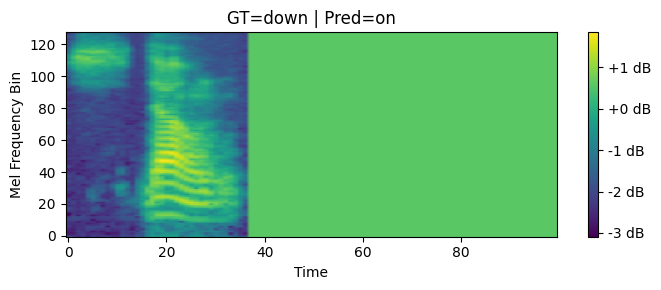

Predicted probabilities:
  yes: 0.0176
  no: 0.1779
  up: 0.0271
  down: 0.1970
  left: 0.0268
  right: 0.0490
  on: 0.2433
  off: 0.0620
  stop: 0.0339
  go: 0.1654


In [9]:
# === (셀 8) 추론 및 결과 시각화 ===
# 학습된 Student 모델을 사용하여 단일 샘플에 대한 추론을 수행하고, 결과를 시각화합니다.
import matplotlib.pyplot as plt
CLASS_NAMES = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

# Student 모델과 검증 데이터셋이 유효한 경우에만 추론 진행
if student and val_ds and len(val_ds) > 0 and CLASS_NAMES:
    # Student 모델을 평가 모드로 설정
    student.eval()

    # 검증 데이터셋(val_ds)에서 첫 번째 샘플 가져오기
    # val_ds[0]는 (스펙트로그램 텐서, 라벨 인덱스) 튜플을 반환합니다.
    spec, y = val_ds[100] # spec shape: (1, n_mels, time), y: 정수형 라벨 인덱스

    # 모델 입력 형태로 변환: (1, 1, n_mels, time) 배치 차원 추가 및 디바이스 이동
    # unsqueeze(0)를 두 번 적용하여 (1, 1, n_mels, time) 형태로 만듭니다.
    # .to(DEVICE): 모델과 동일한 디바이스로 이동
    x = spec.unsqueeze(0).to(DEVICE)  # (Batch=1, Channels=1, Freq, Time)

    # 그래디언트 계산 비활성화 (추론 시에는 역전파 불필요)
    with torch.no_grad():
        # Student 모델 순전파 (로짓 계산)
        logits = student(x) # logits shape: (1, n_classes)

        # 로짓을 확률 분포로 변환 (Softmax)
        # dim=1: 클래스 차원에 대해 Softmax 적용
        # squeeze(): 배치 차원(크기가 1인 차원) 제거 (n_classes,)
        # cpu(): 결과를 CPU 메모리로 이동 (Matplotlib 시각화를 위해 필요)
        # numpy(): PyTorch 텐서를 NumPy 배열로 변환
        prob = logits.softmax(dim=1).squeeze().cpu().numpy() # prob shape: (n_classes,)

    # 예측된 클래스 인덱스 찾기 (확률이 가장 높은 인덱스)
    predicted_idx = int(prob.argmax())
    # 예측된 클래스 인덱스를 클래스 이름(문자열)으로 변환 (전역 변수 CLASS_NAMES 사용)
    # CLASS_NAMES는 셀 2에서 로드된 Speech Commands 클래스 이름 목록입니다.
    pred = CLASS_NAMES[predicted_idx]

    # 실제 정답 클래스 이름 가져오기
    ground_truth_name = CLASS_NAMES[y]

    # 결과 시각화
    # 스펙트로그램 이미지 표시 및 제목, 라벨 추가
    plt.figure(figsize=(7,3)) # 그림 크기 설정
    # imshow: 2D 데이터를 이미지로 표시
    # spec.squeeze().numpy(): (1, n_mels, time) 텐서에서 채널 차원(1) 제거 후 NumPy 배열로 변환
    # origin='lower': 이미지의 y축 원점을 아래로 설정 (주파수 축이 아래에서 위로 증가하도록)
    # aspect='auto': 종횡비 자동 조절
    im = plt.imshow(spec.squeeze().numpy(), origin='lower', aspect='auto')
    plt.title(f"GT={ground_truth_name} | Pred={pred}") # 제목: 정답 라벨과 예측 라벨 표시
    plt.xlabel("Time") # x축 라벨
    plt.ylabel("Mel Frequency Bin") # y축 라벨
    plt.colorbar(im, format='%+2.0f dB') # 컬러바 추가 (데시벨 스케일 표시)
    plt.tight_layout() # 레이아웃 자동 조정
    plt.show() # 그림 표시

    # 예측된 클래스별 확률 출력 (선택 사항)
    print("Predicted probabilities:")
    for i, class_name in enumerate(CLASS_NAMES):
        print(f"  {class_name}: {prob[i]:.4f}")

else:
    print("\nSkipping inference as student model, validation dataset, or class names are not available.")
    if val_ds and len(val_ds) == 0:
        print("Validation dataset is empty.")
    if not CLASS_NAMES:
        print("CLASS_NAMES is not defined.")